Data collection and pre-processing


In [1]:
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip -d fra-eng


--2023-05-08 17:53:41--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7420323 (7.1M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.08M  5.76MB/s    in 1.2s    

2023-05-08 17:53:42 (5.76 MB/s) - ‘fra-eng.zip’ saved [7420323/7420323]

Archive:  fra-eng.zip
  inflating: fra-eng/_about.txt      
  inflating: fra-eng/fra.txt         


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
#import unicodedata
import re
import numpy as np
import pandas as pd
from keras.layers import Layer, Concatenate, Embedding, Input, LSTM, GRU, Dense, Bidirectional, RepeatVector, Activation, Dot, Lambda
import string
from keras.preprocessing.text import Tokenizer
from numpy import zeros

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from numpy import asarray

import matplotlib.pyplot as plt
from keras.utils import plot_model
from nltk.translate.bleu_score import sentence_bleu

In [3]:
# Run this cell to load the dataset

NUM_EXAMPLES = 217975
data_examples = []
with open('fra-eng/fra.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [4]:
#file = open(r'fra-eng/fra.txt', encoding="utf-8") # English to french dataset

In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    return sentence.strip()


In [6]:
# Creating separate lists for English and German sentences, preprocessing them and adding start and end tokens to German sentences
english_sentences = [preprocess_sentence(example.split('\t')[0]) for example in data_examples]
german_sentences = [" ".join(('<start>', preprocess_sentence(example.split('\t')[1]), '<end>')) for example in data_examples]

print("Number of senetence in original corpus : ",len(english_sentences)) # Number of sentences
print("Number of senetence in target corpus : ",len(german_sentences))

# Limit the number of sentences to 10,000 lines (but more than 5,000 lines)
english_sentences = english_sentences[:10000]
german_sentences = german_sentences[:10000]

print("Number of senetence in original corpus : ",len(english_sentences)) # Number of sentences
print("Number of senetence in target corpus : ",len(german_sentences))

Number of senetence in original corpus :  217975
Number of senetence in target corpus :  217975
Number of senetence in original corpus :  10000
Number of senetence in target corpus :  10000


In [7]:
# Split the data into train, development and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(english_sentences, german_sentences, test_size=0.2, random_state=42)

# Print 100th sentence in original script for source and target language
print("\n100th senetnce in Source Language : ",X_train[100]," , Target Language : ",y_train[100])


100th senetnce in Source Language :  can tom dance ?  , Target Language :  <start> tom peut il danser ? <end>


In [8]:
english_sentences = []          # list containing inputs of encoder
german_sentences = []         # list containing output of decoder
german_sentences_inputs = []  # list containing input of decoder

def preprocess(seq):          # Utility function to preprocess strings
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~''' # initializing punctuations string 
    # Removing punctuations in string
    for ele in seq: 
        if ele in punc: 
            seq = seq.replace(ele, "") 
    line = seq.split()
    line = [word.lower() for word in line]
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # remove non-printable chars form each token
    line = [re_print.sub('', w) for w in line]
    return " ".join(line)

for i in range(len(X_train)):
    input_sentence = preprocess(X_train[i])
    output = y_train[i]
    output_sentence = output + ' '
    output_sentence_input = ' ' + output

    english_sentences.append(input_sentence)
    german_sentences.append(output_sentence)
    german_sentences_inputs.append(output_sentence_input)

print("Number of input samples :", len(english_sentences))
print("Number of output samples:", len(german_sentences))
print("Number of input output samples:", len(german_sentences_inputs))

total_input = english_sentences +  [preprocess(line) for line in X_test]
max_input_len = max([len(txt.split()) for txt in total_input])
print("Max length for input : : ",max_input_len)
print("Max length for output:",max([len(txt.split()) for txt in german_sentences]))

unique_input_tokens = set()
for line in total_input:
    words = line.split()
    for word in words:
        unique_input_tokens.add(word)
print("Unique tokens for inputs : ",len(unique_input_tokens))

unique_output_tokens = set()
for line in german_sentences:
    words = line.split()
    for word in words:
        unique_output_tokens.add(word)
print("Unique tokens for outputs : ",len(unique_output_tokens))

# last 5 sentences of preprocessed text
print("\nLast 5 sentences of preprocessed text")
for inpu,outpu in zip(english_sentences[-5:],german_sentences[-5:]):
  print(inpu,"   -->   ",outpu)

Number of input samples : 8000
Number of output samples: 8000
Number of input output samples: 8000
Max length for input : :  5
Max length for output: 16
Unique tokens for inputs :  1962
Unique tokens for outputs :  3153

Last 5 sentences of preprocessed text
it s obvious    -->    <start> a saute aux yeux . <end> 
i love music    -->    <start> j aime beaucoup la musique . <end> 
i m a friend    -->    <start> je suis un ami . <end> 
what fun    -->    <start> qu est ce qu on s est marr s ! <end> 
he has a cold    -->    <start> il a attrap froid . <end> 


In [9]:
# Tokenization (Assign each unique word an integer value)
MAX_NUM_WORDS = 20000

english_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
english_tokenizer.fit_on_texts(total_input)
english_integer_seq = english_tokenizer.texts_to_sequences(english_sentences)
word2idx_inputs = english_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))
max_input_len = max(len(sen) for sen in english_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)


german_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
german_tokenizer.fit_on_texts(german_sentences + german_sentences_inputs)
german_integer_seq = german_tokenizer.texts_to_sequences(german_sentences)
german_english_integer_seq = german_tokenizer.texts_to_sequences(german_sentences_inputs)
word2idx_outputs = german_tokenizer.word_index
word2idx_outputs[''] = 0 # Or some other integer value

print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in german_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)



Total unique words in the input: 1962
Length of longest sentence in input: 5
Total unique words in the output: 3154
Length of longest sentence in the output: 16


In [10]:
# Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences    
encoder_english_sequences = pad_sequences(english_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_english_sequences.shape)
print("encoder_input_sequences[0]:", encoder_english_sequences[0])

decoder_english_sequences = pad_sequences(german_english_integer_seq, maxlen=max_out_len, padding='post') # in the case of the decoder, the post-padding is applied
print("decoder_input_sequences.shape:", decoder_english_sequences.shape)
print("decoder_input_sequences[0]:", decoder_english_sequences[0])
decoder_german_sequences = pad_sequences(german_integer_seq, maxlen=max_out_len, padding='post')

encoder_input_sequences.shape: (8000, 5)
encoder_input_sequences[0]: [  0   0   3   8 673]
decoder_input_sequences.shape: (8000, 16)
decoder_input_sequences[0]: [   1    7    6 1086    3    2    0    0    0    0    0    0    0    0
    0    0]


In [11]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
EMBEDDING_SIZE = 100
embeddings_dictionary = dict()
embedding_matrix = zeros((num_words, EMBEDDING_SIZE)) # dictionary for key: number to value: embedding values of len 100
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Translation Model training

In [12]:
# Model defining
# Output will be a sequence of words, the final shape of the output will be:(number of inputs, length of the output sentence, the number of words in the output)
decoder_targets_one_hot = np.zeros((len(english_sentences),max_out_len,num_words_output),dtype='float32')
print(decoder_targets_one_hot.shape)

# The final layer of the model will be a dense layer, therefore we need the outputs in the form of one-hot encoded vectors,
# since we will be using softmax activation function at the dense layer.
for i, d in enumerate(decoder_german_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1  

(8000, 16, 3155)


# Encoder - decoder with attention

In [13]:
LSTM_NODES =256
BATCH_SIZE = 64
EPOCHS = 100

# Creating a BiLSTM Attention based model

# Embedding
embedding = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

# Encoder
input_layer_encoder = Input(shape=(max_input_len,))
embed_encoder = embedding(input_layer_encoder)
encoder = Bidirectional(LSTM(LSTM_NODES, return_sequences=True, dropout=0.2))
encoder_out = encoder(embed_encoder)

# Decoder input
input_layer_decoder = Input(shape=(max_out_len,))
embed_decoder = Embedding(num_words_output, EMBEDDING_SIZE)
decoder_input = embed_decoder(input_layer_decoder)

# Decoder output, after attention
decoder = LSTM(LSTM_NODES, return_state=True)
dense_decode = Dense(num_words_output, activation='softmax')
s0 = Input(shape=(LSTM_NODES,))
c0 = Input(shape=(LSTM_NODES,))

In [14]:
def softmax(x):
    assert(K.ndim(x) > 2) #Dimension x = N x T x D
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

# Some of the common layers for attention
repeat_attn = RepeatVector(max_input_len)
concat_attn = Concatenate(axis=-1)
dense1_attn = Dense(10, activation='tanh')  # over time dimension T
dense2_attn = Dense(1, activation=softmax)
dot_attn = Dot(axes=1)                      # over time dimension T

def iterAttn(h, prevOut):
    #  h: encoder encoded hidden states at all time.
    # prevOut: output at the previous time (word).
    # An iteration of attention.
    prevOutRepeat = repeat_attn(prevOut) 
    total = concat_attn([h, prevOutRepeat]) 
    d = dense1_attn(total)
    alphaLayer = dense2_attn(d)
    context = dot_attn([alphaLayer, h])
    return context

In [15]:
# Initializing with start states
s = s0
c = c0
# Executing encoder-decoder and attention (with teacher forcing) inference for Ty time to get output
all_out = []
for t in range(max_out_len):
    # Get context vector with encoder and attention
    context = iterAttn(encoder_out, s) 
    # For teacher forcing, get the previous word
    select_layer = Lambda(lambda x: x[:, t:t+1])
    prevWord = select_layer(decoder_input)
    # Concat context and previous word as decoder input
    concat2 = Concatenate(axis=2)
    decoder_in_concat = concat2([context, prevWord])
    # pass into decoder, inference output
    pred, s, c = decoder(decoder_in_concat, initial_state=[s, c])
    pred = dense_decode(pred)
    all_out.append(pred)
       
def stack(outputs):
    outputs = K.stack(outputs)
    return K.permute_dimensions(outputs, pattern=(1, 0, 2))

stack_layer = Lambda(stack)
all_out = stack_layer(all_out)

In [16]:
attnModel = Model(inputs=[input_layer_encoder, input_layer_decoder, s0, c0,],
                 outputs=all_out)

In [17]:
# Defining cutomized loss and accuracy
def myLoss(y_train, pred):
    mask = K.cast(y_train > 0, dtype='float32')
    val = mask * y_train * K.log(pred)
    return -K.sum(val) / K.sum(mask)

def acc(y_train, pred):
    targ = K.argmax(y_train, axis=-1)
    pred = K.argmax(pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')
    mask = K.cast(K.greater(targ, 0), dtype='float32') # filter out padding value 0.
    correctCount = K.sum(mask * correct)
    totalCount = K.sum(mask)
    return correctCount / totalCount

In [18]:
attnModel.compile(optimizer='adam', loss=myLoss, metrics=[acc]) # Training with Adam optimizer and customized loss and accuracy

# Defining empty s0 and c0
init_s = np.zeros((len(encoder_english_sequences), LSTM_NODES))
init_c = np.zeros((len(encoder_english_sequences), LSTM_NODES))

EPOCHS = 100
history = attnModel.fit(x=[encoder_english_sequences, decoder_german_sequences, init_s, init_c],y=decoder_targets_one_hot,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.2)

Epoch 1/100
100/100 [==============================] - 51s 214ms/step - loss: 2.8937 - acc: 0.0978 - val_loss: 1.9154 - val_acc: 0.1767
Epoch 2/100
100/100 [==============================] - 6s 60ms/step - loss: 1.7616 - acc: 0.2437 - val_loss: 1.7542 - val_acc: 0.2178
Epoch 3/100
100/100 [==============================] - 6s 63ms/step - loss: 1.6416 - acc: 0.3150 - val_loss: 1.6925 - val_acc: 0.3244
Epoch 4/100
100/100 [==============================] - 6s 56ms/step - loss: 1.5892 - acc: 0.3464 - val_loss: 1.6693 - val_acc: 0.3441
Epoch 5/100
100/100 [==============================] - 6s 60ms/step - loss: 1.5566 - acc: 0.3564 - val_loss: 1.6605 - val_acc: 0.3211
Epoch 6/100
100/100 [==============================] - 5s 54ms/step - loss: 1.5330 - acc: 0.3616 - val_loss: 1.6342 - val_acc: 0.3406
Epoch 7/100
100/100 [==============================] - 6s 59ms/step - loss: 1.5114 - acc: 0.3660 - val_loss: 1.6767 - val_acc: 0.3536
Epoch 8/100
100/100 [==============================] - 5s 50

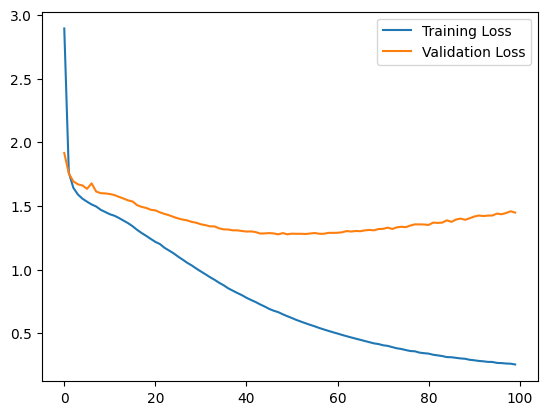

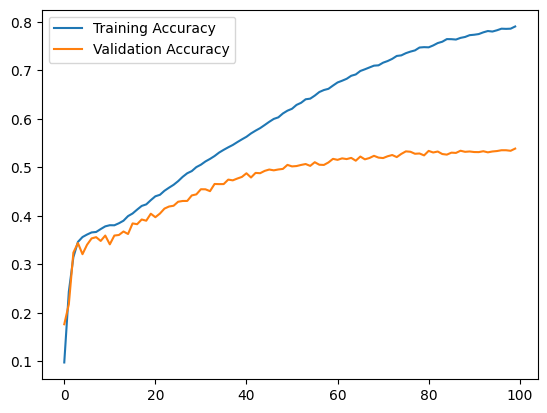

In [19]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss") 
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["acc"], label="Training Accuracy")
plt.plot(history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.show()

In [20]:
# Inference model
# Encoder
encoder_inf = Model(input_layer_encoder, encoder_out)
encoder_out_inf = Input(shape=(max_input_len, LSTM_NODES * 2,))

# Decoder
decoder_in_inf = Input(shape=(1,))
decoder_in_embed_inf = embed_decoder(decoder_in_inf)

# Context, concat without teacher forcing.
context_inf = iterAttn(encoder_out_inf, s0)
decoder_in_concat_inf = concat2([context_inf, decoder_in_embed_inf])

# Decoder inference
pred, s, c = decoder(decoder_in_concat_inf, initial_state=[s0, c0])
pred_out = dense_decode(pred)

# Define model
decoder_inf = Model(inputs=[decoder_in_inf, encoder_out_inf, s0, c0],outputs=[pred_out, s, c])
     

In [21]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

def inference_att(eng_seq):
    encoder_output = encoder_inf.predict(eng_seq) # Encode
    # Create output seq matrix
    target_output = np.zeros((1, 1))
    target_output[0, 0] = word2idx_outputs['']
    
    # init
    eos = word2idx_outputs['']
    s0 = np.zeros((1, LSTM_NODES))
    c0 = np.zeros((1, LSTM_NODES))
    output_seq = []
    s = s0
    c = c0
    for _ in range(max_out_len):
        # Decoder inference
        pred, s, c = decoder_inf.predict([target_output, encoder_output, s, c])
        
        # update output seq
        tok = np.argmax(pred.flatten())
        if tok == eos:
            break
        if tok > 0:
            word = idx2word_target[tok]
            output_seq.append(word)

        # Update decoder input
        target_output[0, 0] = tok
      
    sentence = ' '.join(output_seq)
    return sentence

In [22]:
for _ in range(30):
    i = np.random.choice(len(english_sentences))
    eng_sen = encoder_english_sequences[i:i+1]
    translation = inference_att(eng_sen)
    print('*********************************************')
    print('English: {}'.format(english_sentences[i]))
    print('Prediction: {}'.format(translation))
    print('Ground truth: {}'.format(german_sentences[i]))
    

1/1 [==============================] - 0s 24ms/step
*********************************************
English: i m a farmer
Prediction: <start> je suis fermier . <end> <end>
Ground truth: <start> je suis fermier . <end> 
1/1 [==============================] - 0s 23ms/step
*********************************************
English: let s split
Prediction: <start> s nous nous <end> <end>
Ground truth: <start> divisons nous ! <end> 
1/1 [==============================] - 0s 22ms/step
*********************************************
English: keep quiet
Prediction: <start> restez tranquille ! <end>
Ground truth: <start> restez tranquilles . <end> 
1/1 [==============================] - 0s 23ms/step
*********************************************
English: run
Prediction: <start> courez ! <end> <end>
Ground truth: <start> prenez vos jambes vos cous ! <end> 
1/1 [==============================] - 0s 20ms/step
*********************************************
English: i was asleep
Prediction: <start> j tais endo

In [23]:
# Automatic evaluation with the BLEU metric
def encode_to_input(s):
    s = preprocess(s)
    x  = []
    for w in s.split():
        x.append(word2idx_inputs[w.lower()])
    return pad_sequences([x], maxlen=max_input_len)

def evaluate_model(X,Y):
    count = 0
    total_score = 0
    for x,y in zip(X,Y):
        encoded_x = encode_to_input(x)
        translated_x = inference_att(encoded_x)
        reference = [y.split()]
        candidate = translated_x.split()
        blue_score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
        count = count +1
        total_score = total_score + blue_score
        if count%100==0:
          print(count,blue_score,total_score,x,y)
    return total_score/count

average_score_att = evaluate_model(X_test,y_test)


1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
1500 0.6191984998215584 947.4942908857787 i messed up . <start> j ai mis le souk . <end>
1/1 [==============================] - 0s 33ms/step
1600 0.5 1010.6443926048248 tom says hi . <start> tom te donne le bonjour . <end>
1/1 [==============================] - 0s 31ms/step
1700 0.7142857142857143 1075.5300752228736 he s lazy . <start> il est paresseux . <end>
1/1 [==============================] - 0s 28ms/step
1800 0.8888888888888888 1139.4359269919496 is that sweet ? <start> est ce que c est sucr ? <end>
1/1 [==============================] - 0s 33ms/step
1900 0.6666666666666666 1204.5073401150787 you re sick ! <start> tu es malade ! <end>
1/1 [==============================] - 0s 35ms/step
2000 0.6666666666666666 1269.482398031548 are you there ? <start> t es l ? <end>


In [24]:
print("Average BLEU score",average_score_att)

Average BLEU score 0.634741199015774
